In [1]:
import numpy as np
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt
from scipy.linalg import eig
from cycler import cycler
import pandas as pd
import seaborn as sns

plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

def svd_jacs(test_id_first, start, end, interval, seed, sigmas, m):
    jacs = {i:[] for i in range(start, end, interval)}
    us = {i:[] for i in range(start, end, interval)}
    vts = {i:[] for i in range(start, end, interval)}
    test_id = test_id_first + str(seed)
    for i in range(start, end, interval):
        str_i = f'{i:04d}'
        mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy')
        if sigmas:
            L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')

        u, s, vt = cal_W(mat, L, m)
        jacs[i].append(s)
        us[i].append(u)
        vts[i].append(vt)

    return jacs, us, vts

def plot_singular_cum(test_id_first, m = 'all', seed = 0, window=5, window2='all', start=1, end=16435, interval=108, seq_len=30, sigmas=True, log_bool=False):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    singular, us, vts = svd_jacs(test_id_first, start, end, interval, seed, sigmas, m)
    gn_dic = {}
    fig1, ax1 = plt.subplots(figsize=(5, 4), dpi=150)
    fig2, ax2 = plt.subplots(figsize=(5, 4), dpi=150)

    for i in range(start, end, interval):
        jac_arr = np.array(singular[i])
        if log_bool:
            jac_arr = np.log(jac_arr)
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean_cum = np.cumsum(jac_mean)
        jac_mean_cum /= jac_mean_cum[-1]
        gn = gini(jac_mean_cum)
        
        time_start = start_date + pd.Timedelta(days=i+seq_len)
        time_end = time_start + pd.Timedelta(days=interval)
        time_str = time_start.strftime("%Y-%m-%d") + '--' + time_end.strftime("%Y-%m-%d")
        gn_dic[time_str] = gn
        ax1.plot(jac_mean[:window], 
                label=time_str, 
                alpha=0.5)
        # plt.fill_between(range(window), jac_mean[:window]+jac_std[:window], jac_mean[:window]-jac_std[:window], alpha=0.15)

        if window2 == 'all':
            ax2.plot(jac_mean_cum, label=time_str, alpha=0.5)
        else:
            ax2.plot(jac_mean_cum[:window2], label=time_str, alpha=0.5)
    ax2.set_xlabel("singular value index")
    #plt.xticks(range(window), [1+i for i in range(window)])
    ax2.set_ylabel("singular cumsum(normalized)")
    # plt.ylim([0.4,1])
    # plt.xlim([0,50])
    ax2.legend(loc=[1.01,0])

    ax1.set_xlabel("singular value index")
    ax1.set_xticks(range(window), [1+i for i in range(window)])
    ax1.set_ylabel("singular value")
    ax1.legend(loc=[1.01,0])
 
    return gn_dic, singular, us, vts

def analysis_u(us, seq_len, dims, start, end, interval, target):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    for j in target:
        for i in range(start, end, interval):
            time_start = start_date + pd.Timedelta(days=i+seq_len)
            time_end = time_start + pd.Timedelta(days=interval)
            time_str = time_start.strftime("%Y-%m-%d") + '--' + time_end.strftime("%Y-%m-%d")
            u = np.array(us[i])
            u_col1 = u[0, :, j]
            u_col1 = u_col1.reshape(seq_len,dims)
            u_col1 = np.abs(u_col1)
            plt.figure()
            sns.heatmap(u_col1)
            plt.xlabel('space')
            plt.ylabel('time')
            plt.title(time_str+"_index={0}".format(j))
            
def create_block_diagonal_matrix(matrix1, matrix2):
    if matrix1.ndim != 2 or matrix2.ndim != 2:
        raise ValueError("The input matrix must be two-dimensional.")
    if matrix1.shape[0] != matrix1.shape[1] or matrix2.shape[0] != matrix2.shape[1]:
        raise ValueError("The input matrix must be a square matrix.")
    n1 = matrix1.shape[0]
    n2 = matrix2.shape[0]
    result_dim = n1 + n2
    result = np.zeros((result_dim, result_dim), dtype=matrix1.dtype)
    result[:n1, :n1] = matrix1
    result[n1:, n1:] = matrix2
    return result

def cal_W(A, Sigma, m):
    n = A.shape[0]
    matrix_a = np.conj(A).T @ np.linalg.inv(Sigma) @ A
    matrix_b = np.linalg.inv(Sigma)
    block_matrix = create_block_diagonal_matrix(matrix_a, matrix_b)
    U, S, VT = np.linalg.svd(block_matrix)
    if m == "all":
        U = np.abs(U)
    else:
        U = np.abs(U)[:, :m]
        S = S[:m]
    U2 = U[:n,:] + U[n:,:]
    U2 = U2 @ np.diag(S)
    U2U, S2, V2T = np.linalg.svd(U2)
    return U2U, S2, V2T

# 日资料分析

<ipython-input-1-523c76de27e6>:69: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax1.set_xticks(range(window), [1+i for i in range(window)])


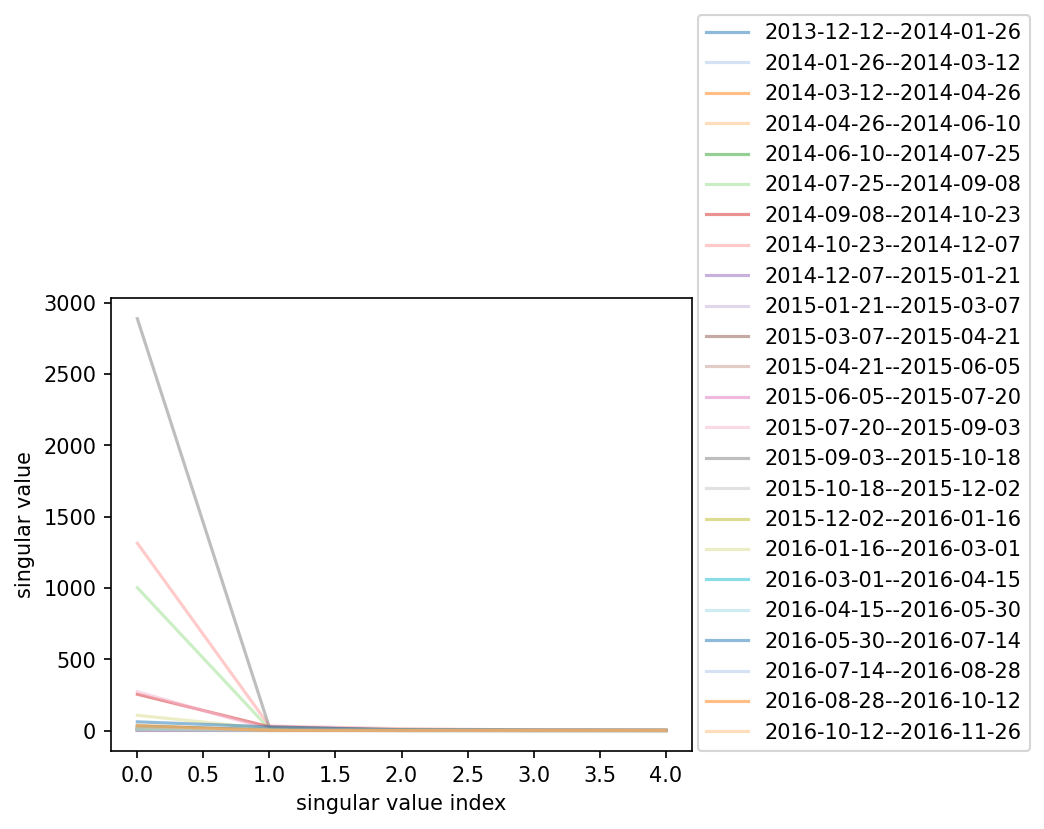

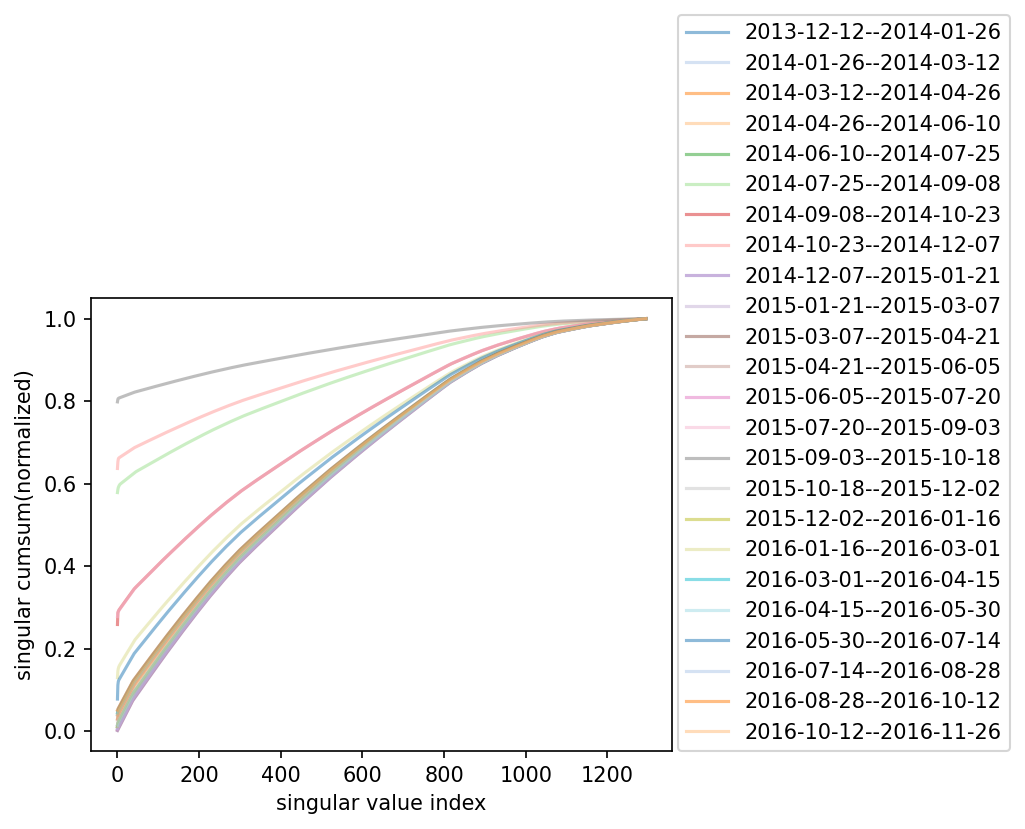

In [2]:
test_id = 'long_term_forecast_iT_cov_qbo_daily_iTransformer_cov_QBO_ft-1_sl35_pl35_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
start = 12734
end = 13814
interval = 45
gn_dic, singular, us, vts = plot_singular_cum(test_id, m='all', seed = 0, start=start, end=end, interval=interval, sigmas=True, log_bool=False)

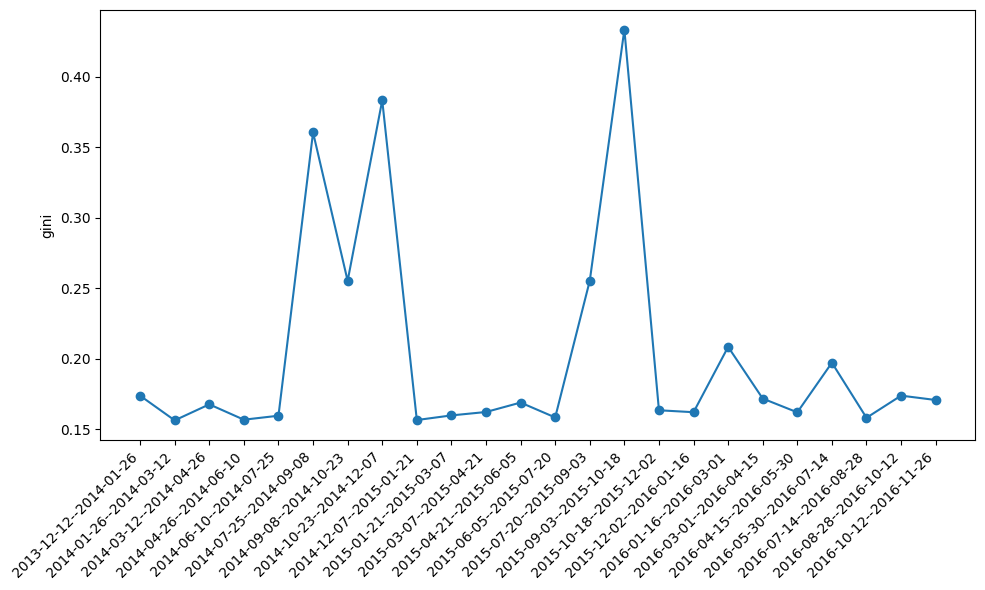

In [12]:
# 提取 key 与 value
x_labels = list(gn_dic.keys())
y_values = list(gn_dic.values())

# 创建折线图
plt.figure(figsize=(10, 6))
plt.plot(x_labels, y_values, marker='o')

# 设置坐标轴和标题
# plt.xlabel("Category")
plt.ylabel("gini")
# plt.title("Line Chart for Dict Data")

# 旋转 x 轴标签，防止重叠
plt.xticks(rotation=45, ha='right')

# 可选：调整布局防止标签被截断
plt.tight_layout()

plt.show()

/tmp/ipykernel_5986/2962746596.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


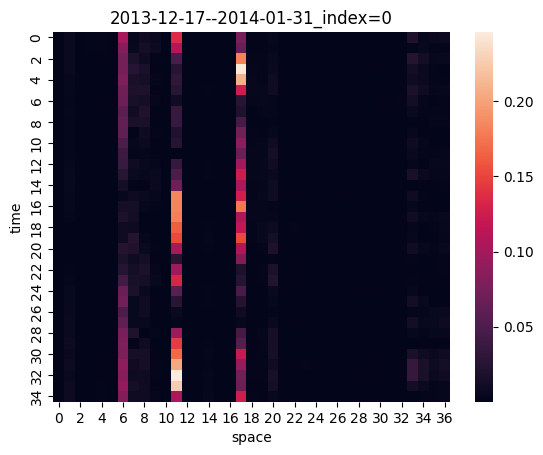

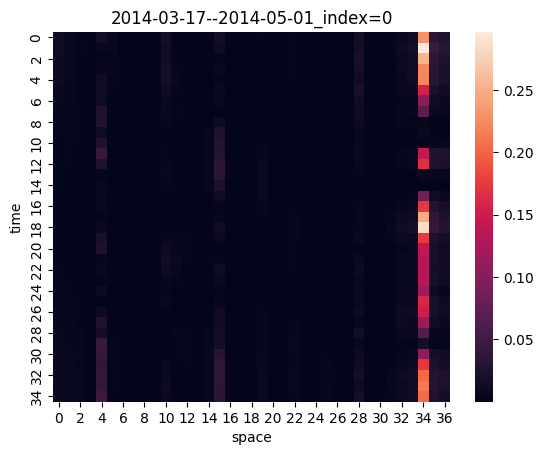

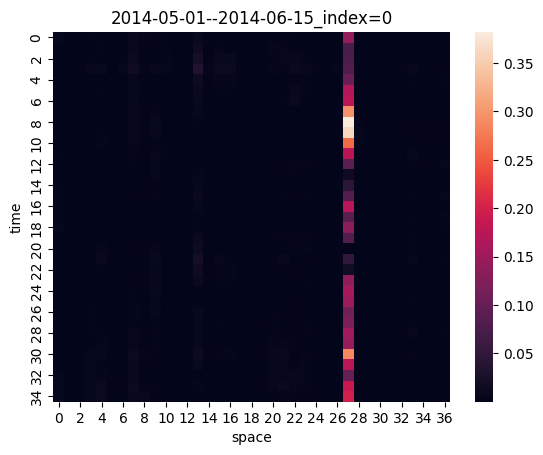

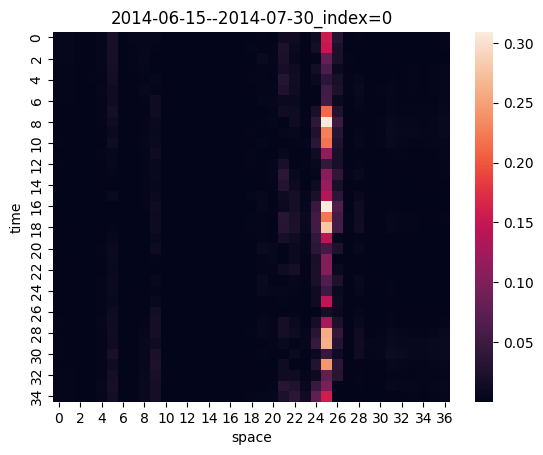

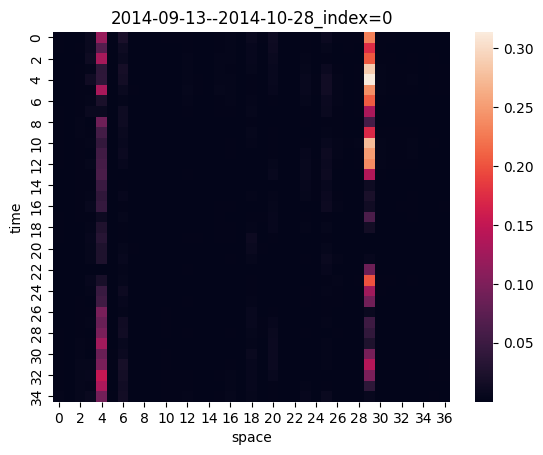

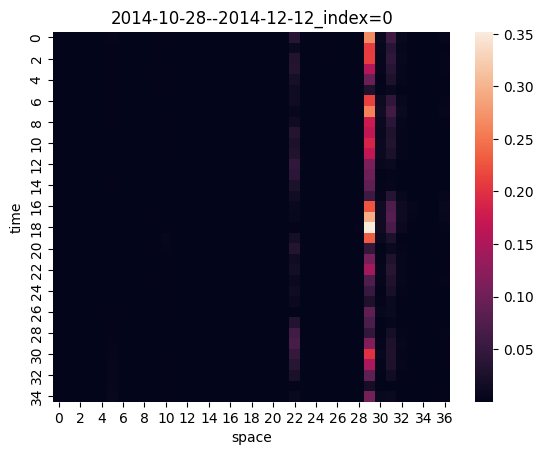

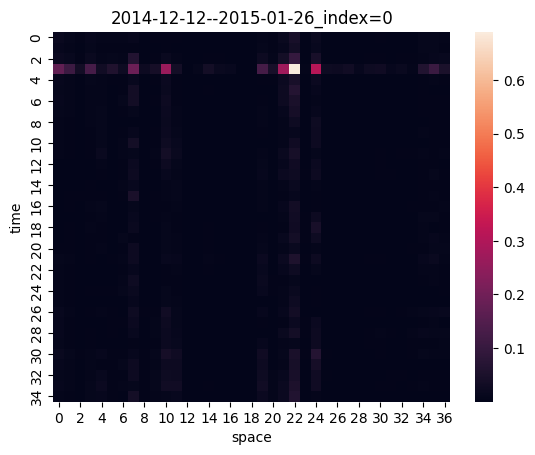

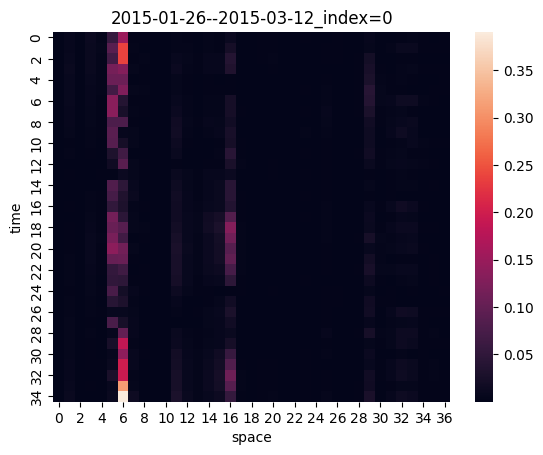

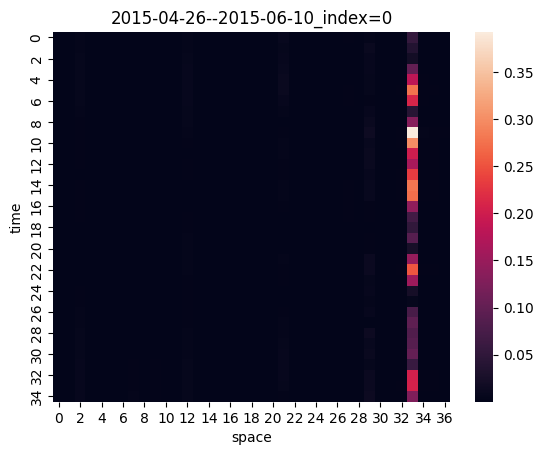

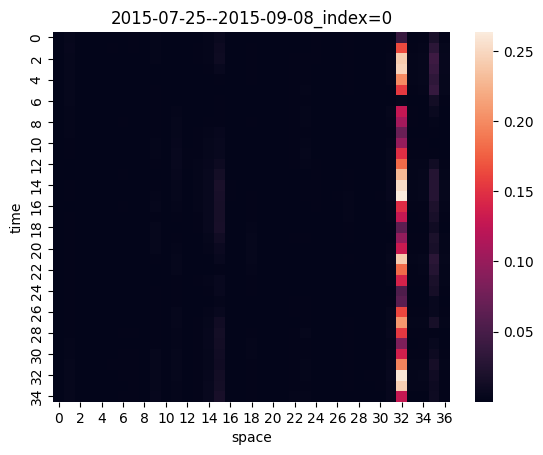

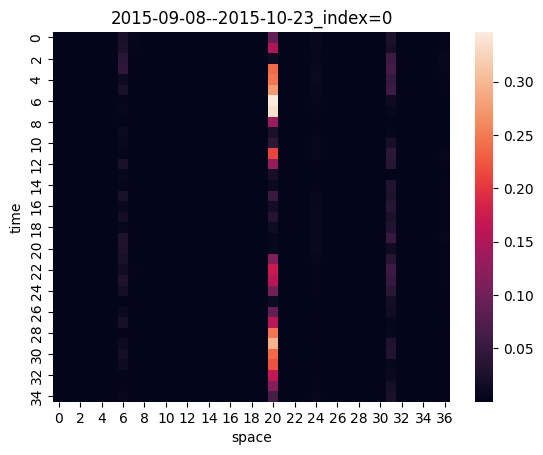

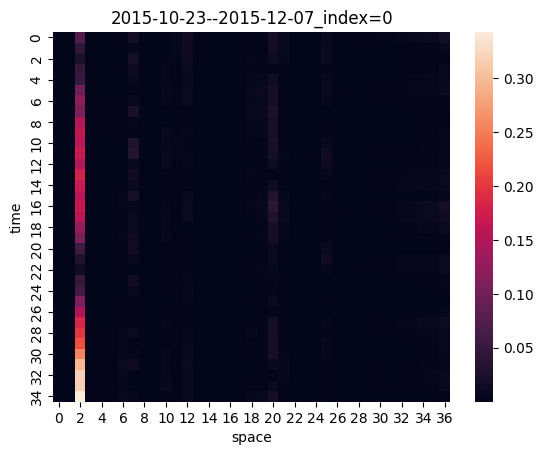

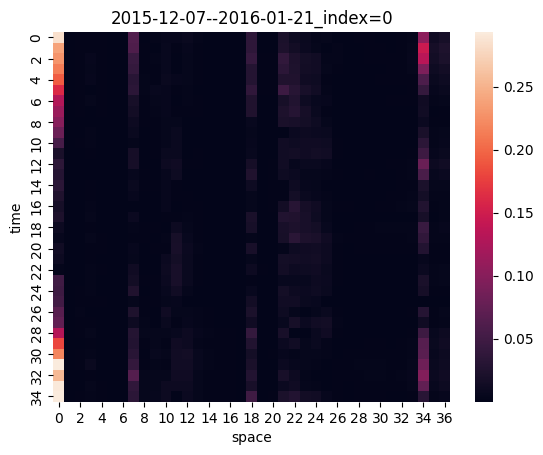

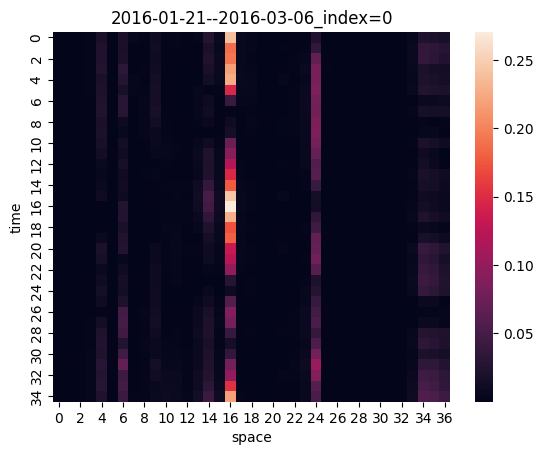

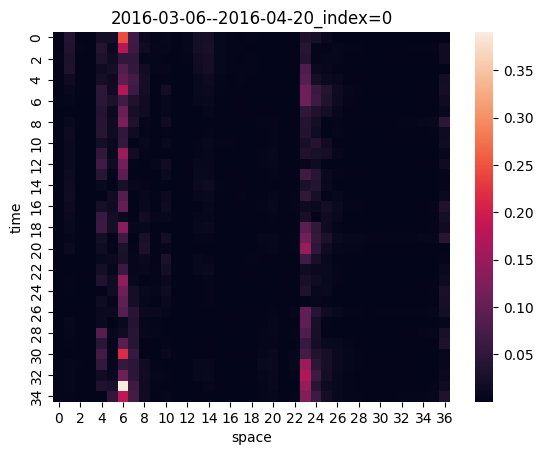

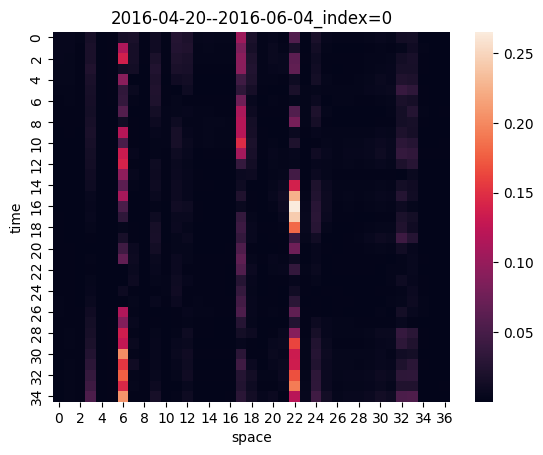

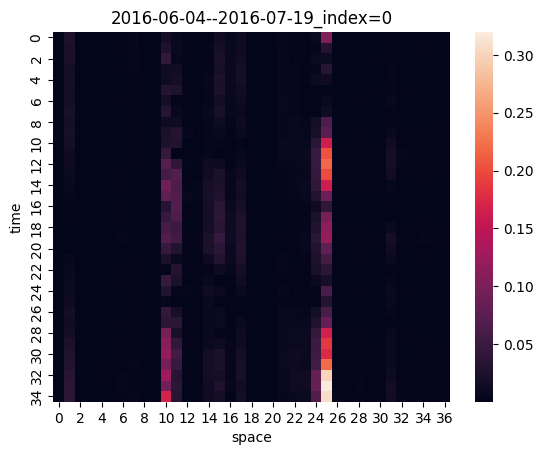

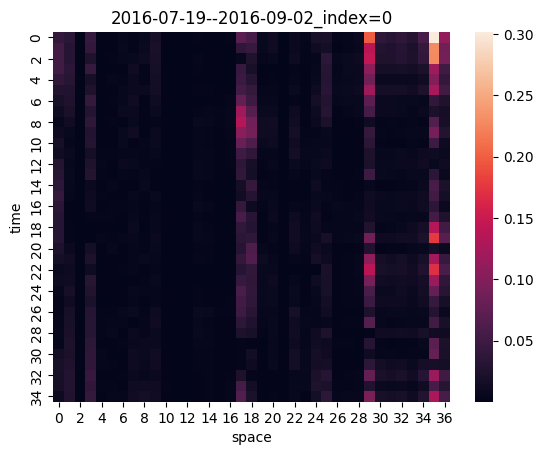

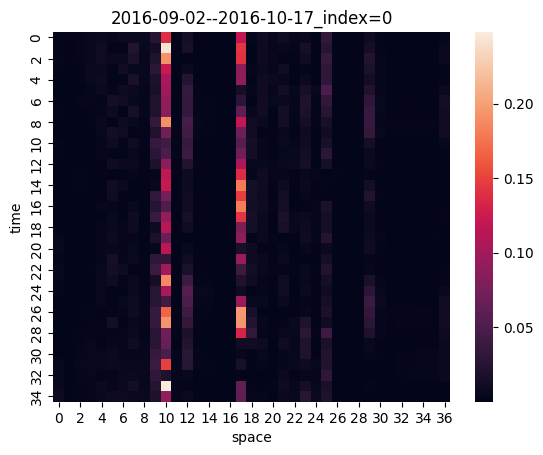

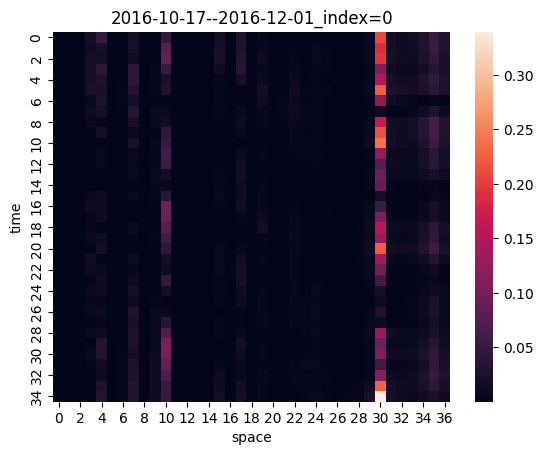

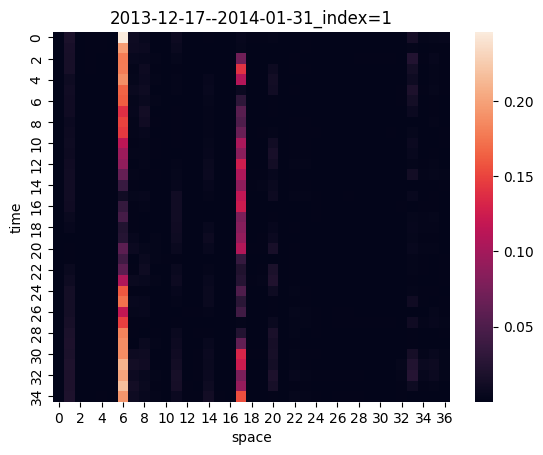

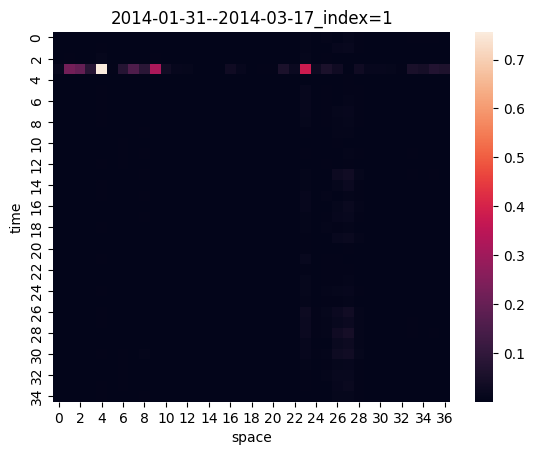

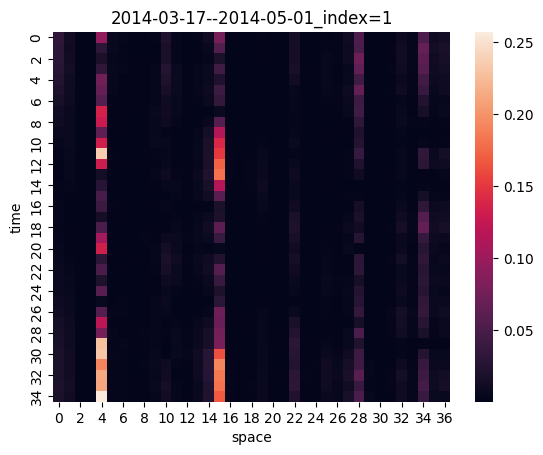

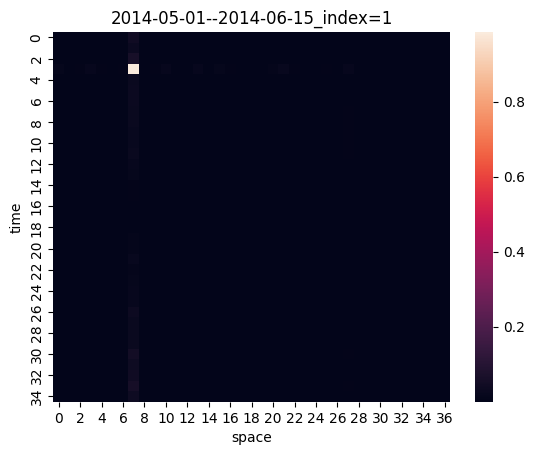

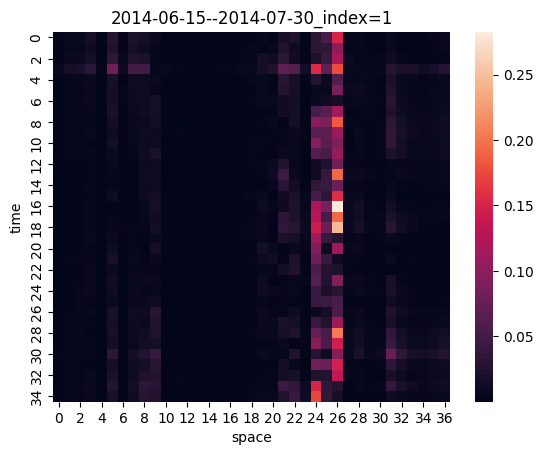

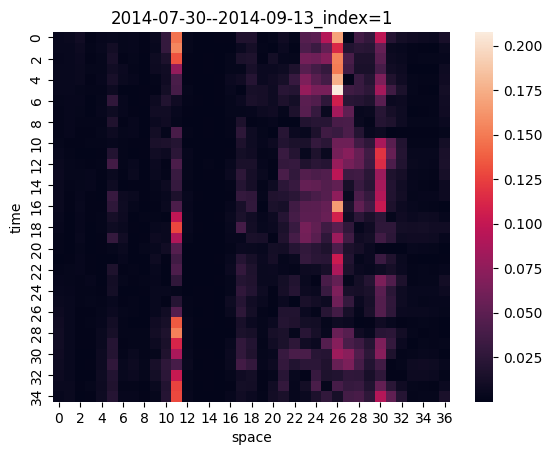

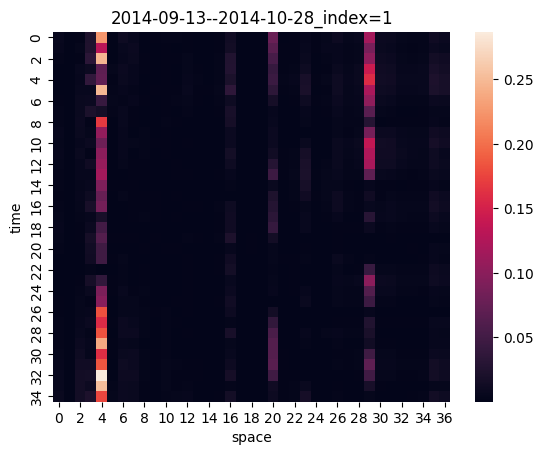

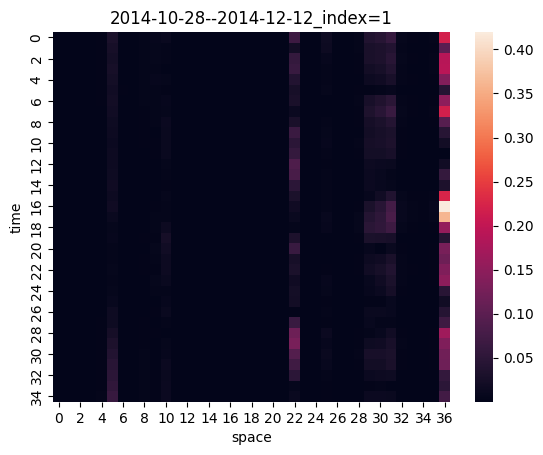

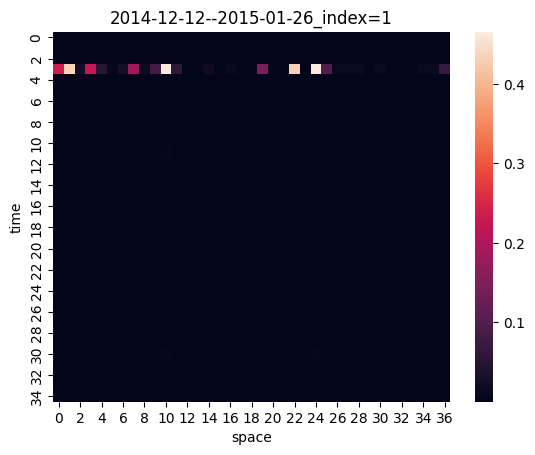

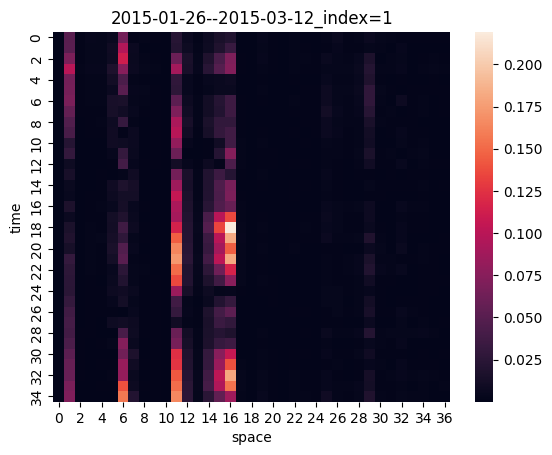

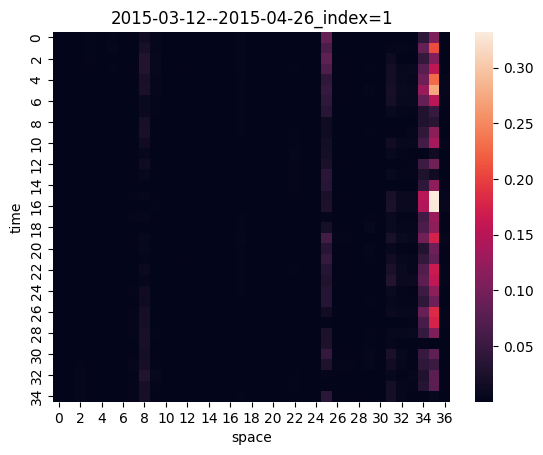

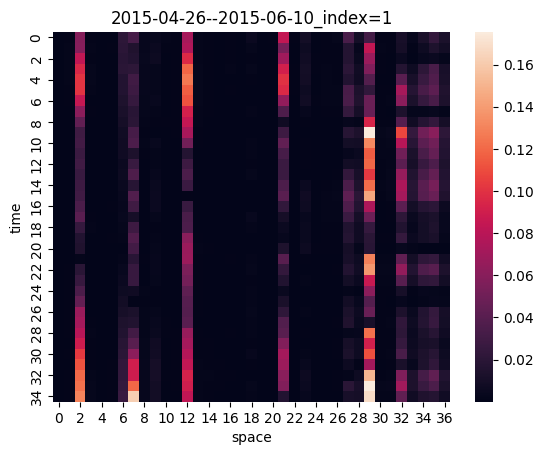

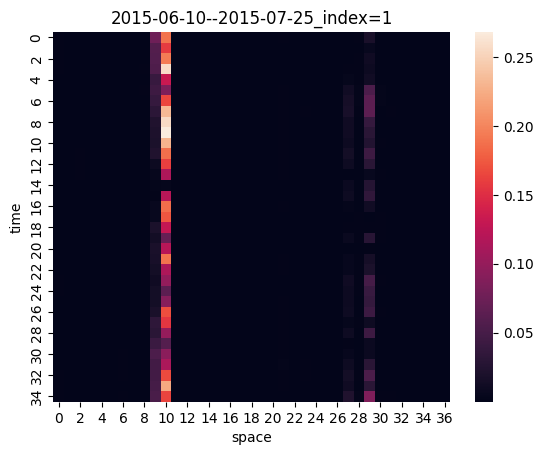

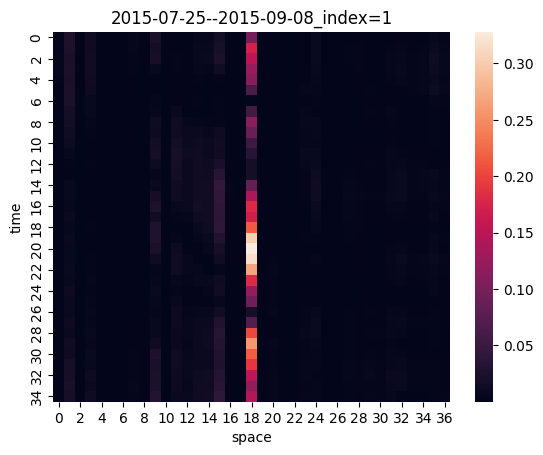

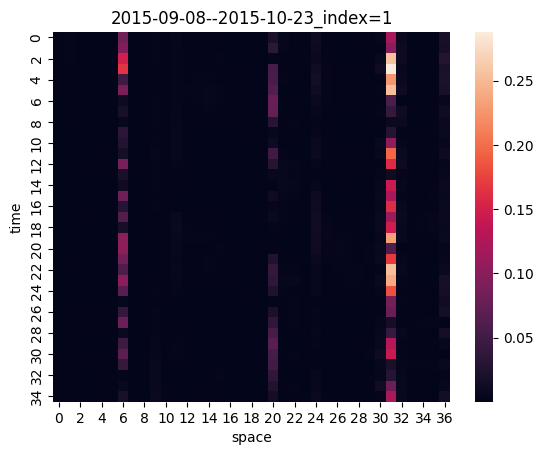

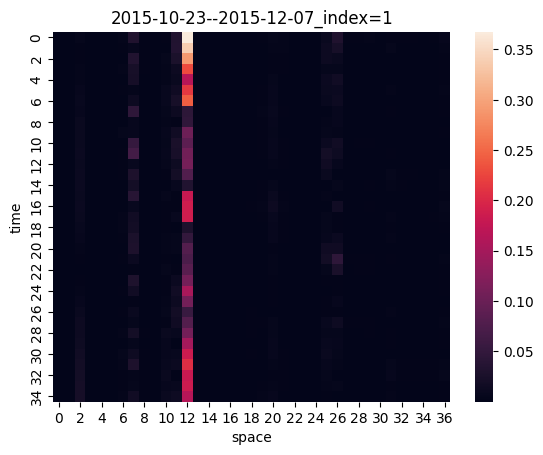

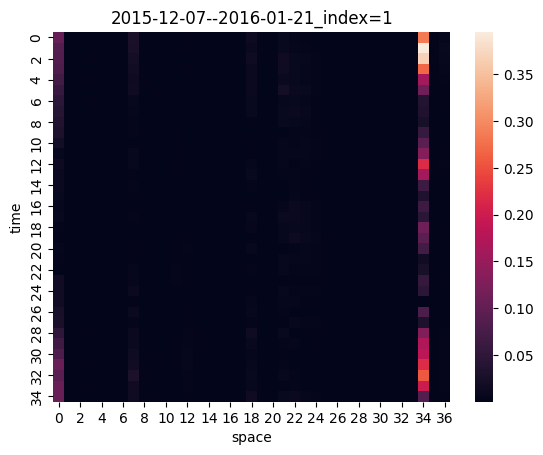

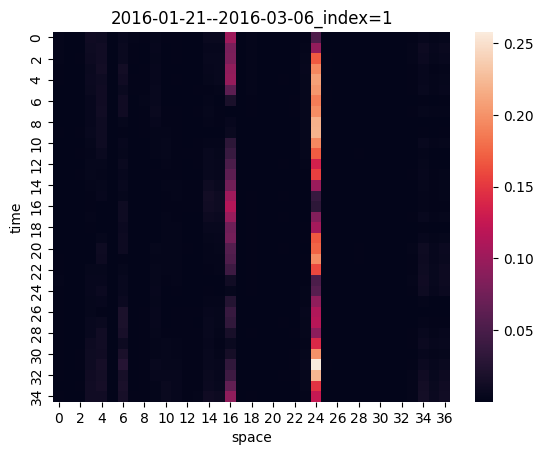

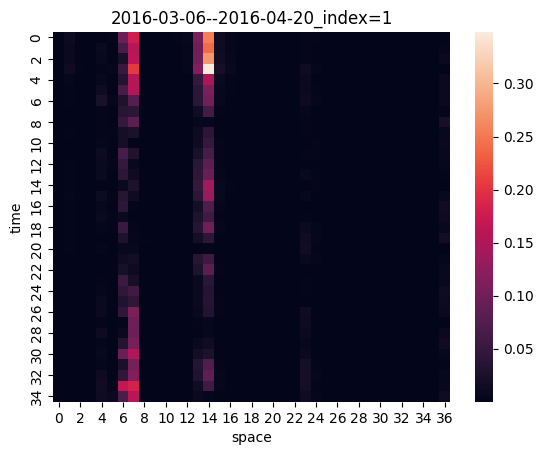

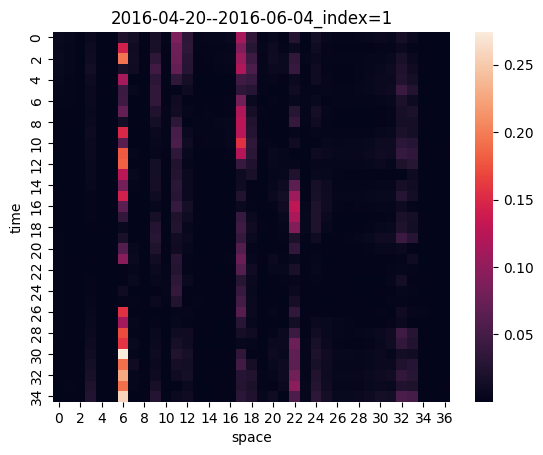

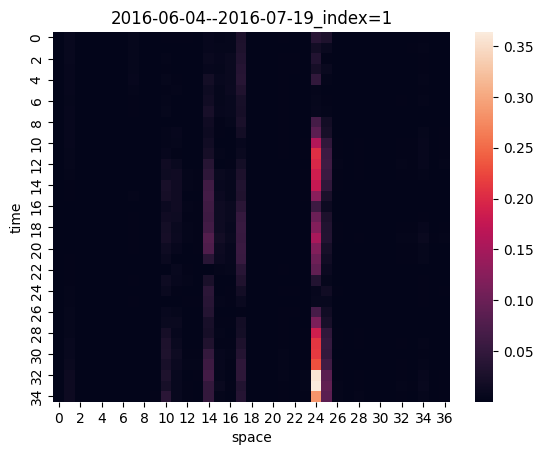

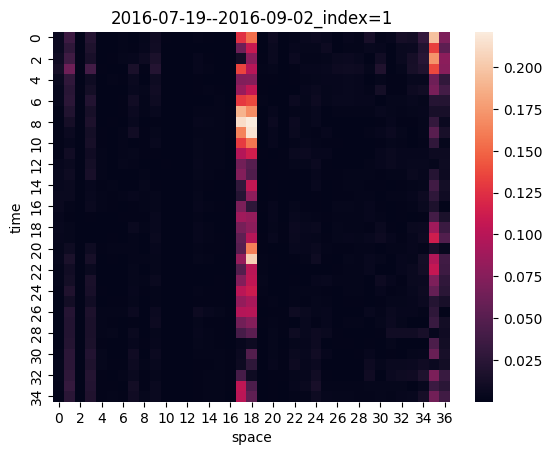

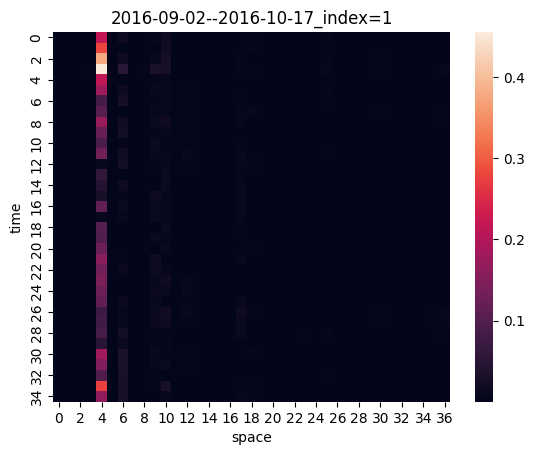

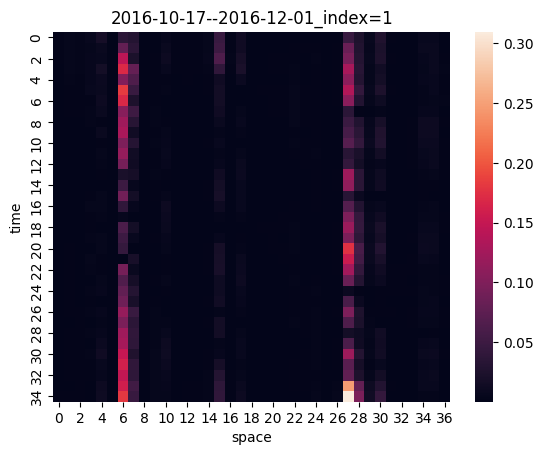

In [11]:
analysis_u(us, seq_len=35, dims=37, start=start, end=end, interval=interval, target=[0,1])

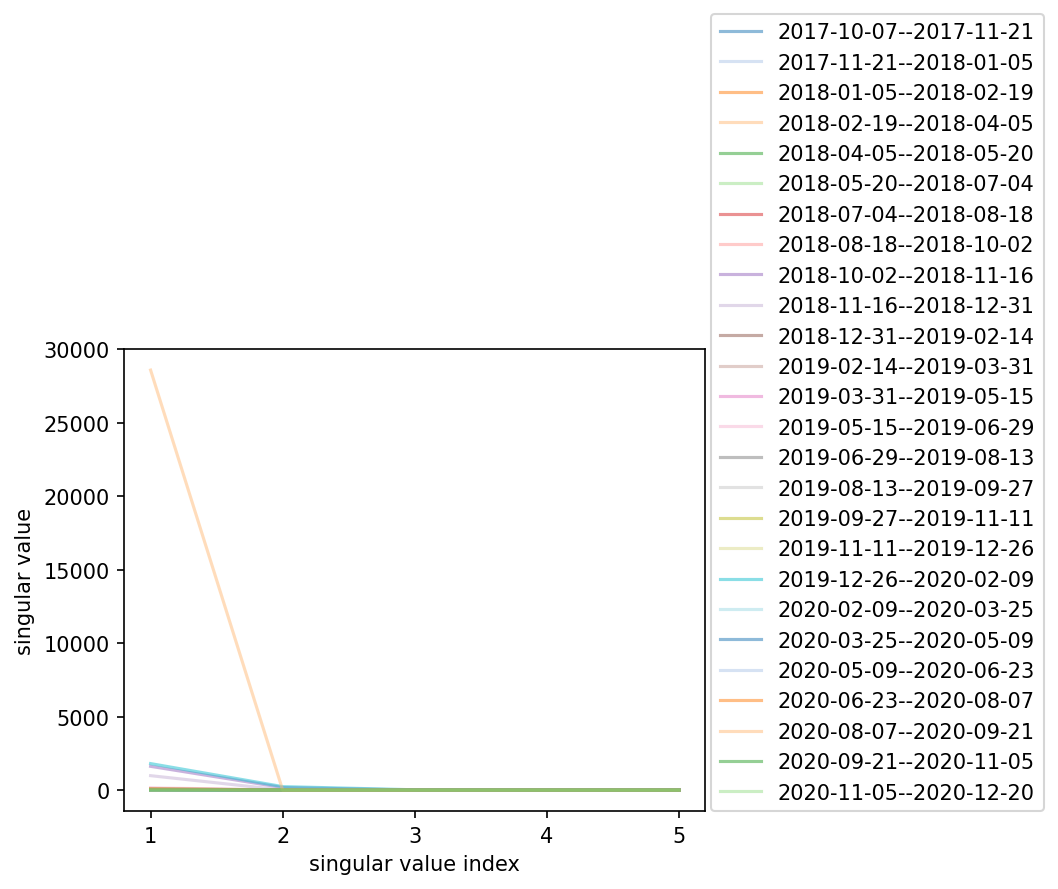

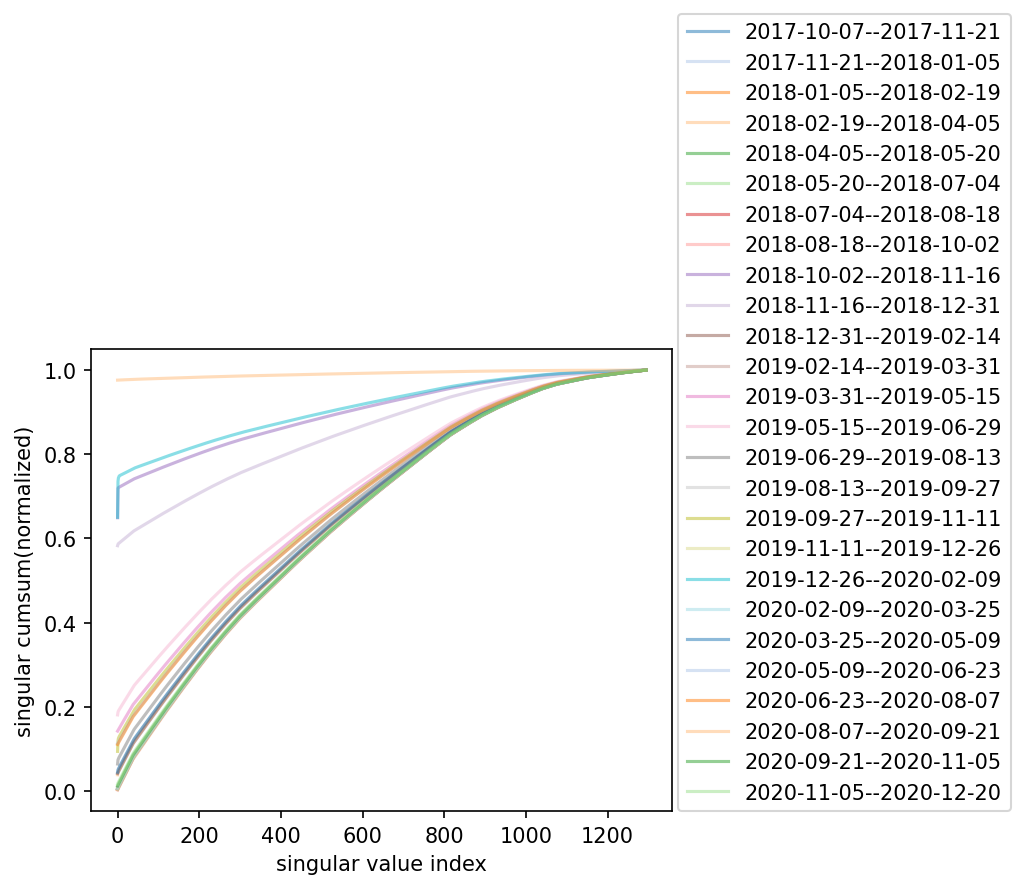

In [13]:
start = 14129
end = 15299
gn_dic, singular, us, vts = plot_singular_cum(test_id, m='all', seed = 0, start=start, end=end, interval=interval, sigmas=True, log_bool=False)

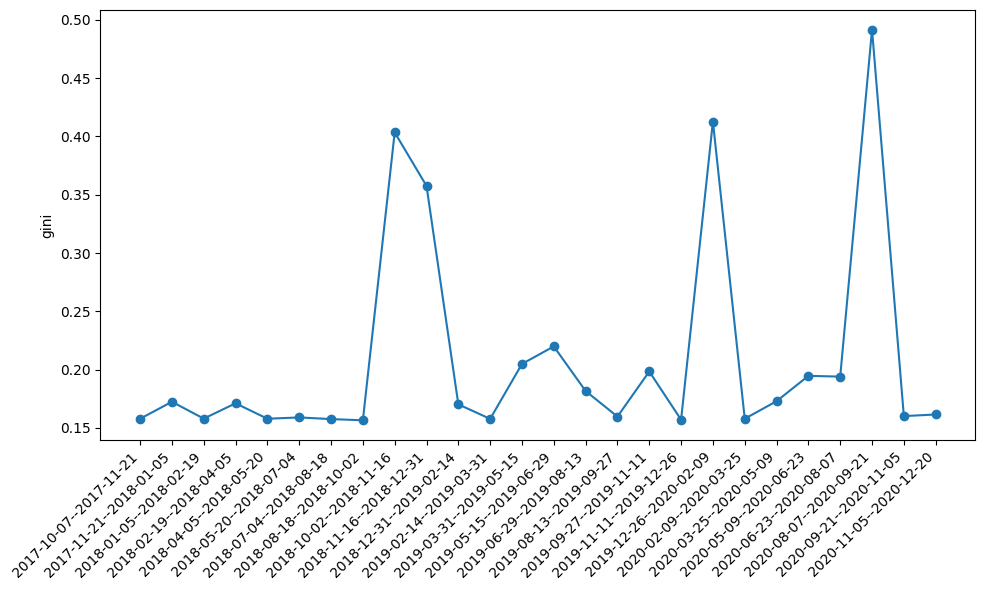

In [14]:
# 提取 key 与 value
x_labels = list(gn_dic.keys())
y_values = list(gn_dic.values())

# 创建折线图
plt.figure(figsize=(10, 6))
plt.plot(x_labels, y_values, marker='o')

# 设置坐标轴和标题
# plt.xlabel("Category")
plt.ylabel("gini")
# plt.title("Line Chart for Dict Data")

# 旋转 x 轴标签，防止重叠
plt.xticks(rotation=45, ha='right')

# 可选：调整布局防止标签被截断
plt.tight_layout()

plt.show()

In [ ]:
analysis_u(us, seq_len=35, dims=37, start=start, end=end, interval=interval, target=[0,1])

# 其他结果

{'2013-03-03': 0.4994369389832829,
 '2013-06-07': 0.4994369390915926,
 '2013-09-11': 0.4994369428523261,
 '2013-12-16': 0.49943694141055883,
 '2014-03-22': 0.49943678227321475,
 '2014-06-26': 0.49943694003671923,
 '2014-09-30': 0.4994369484550083,
 '2015-01-04': 0.4994369356534134,
 '2015-04-10': 0.4994369378781157,
 '2015-07-15': 0.4994369383431725,
 '2015-10-19': 0.49943659491027614,
 '2016-01-23': 0.49943544927366534,
 '2016-04-28': 0.49943534159141745,
 '2016-08-02': 0.49943693899980224}

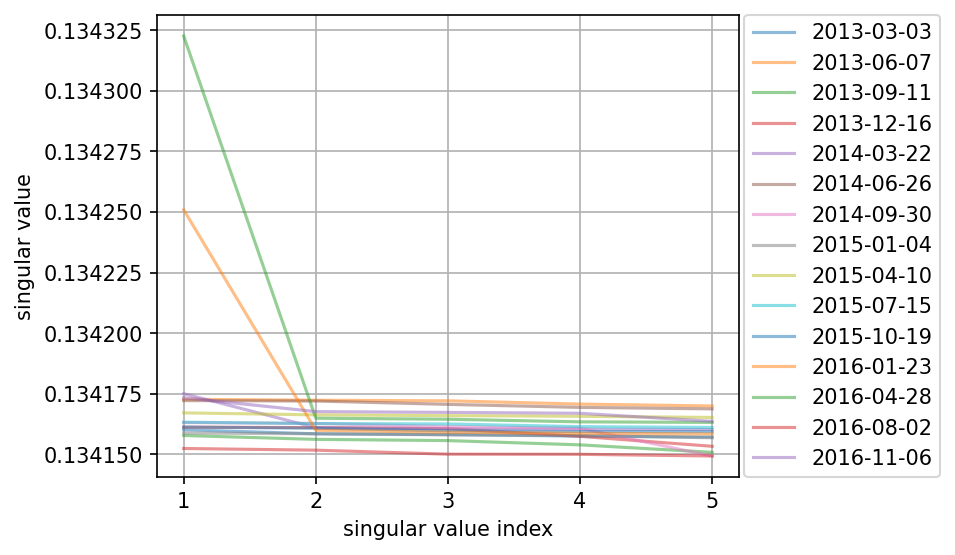

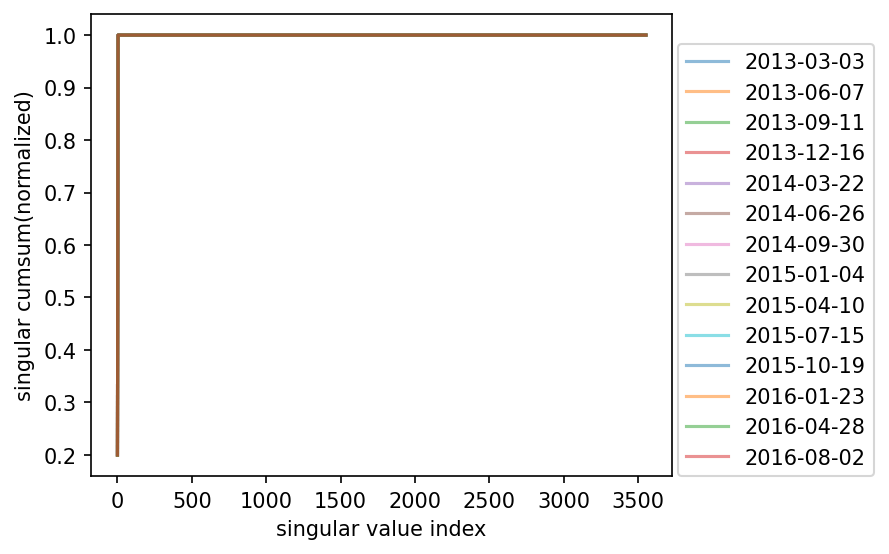

In [24]:
test_id = 'long_term_forecast_iT_cov_qbo_daily_iTransformer_QBO_ft5_sl96_pl96_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.0_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=96, dims=5, start=12480, end=13824, interval=96, window=5, sigmas=False)
plot_singular_cum(test_id, seeds = 1, length=96, dims=5, start=12480, end=13824, interval=96, window='all', sigmas=False, figure_show=True)

# 对f(x)的Jacobian矩阵做SVD分解

In [2]:
#test_id_first = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl1_pl1_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"
def plot_singular(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_std = np.std(jac_arr, axis=0)


        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)
        plt.fill_between(range(window), jac_mean[:window]+jac_std[:window], jac_mean[:window]-jac_std[:window], alpha=0.15)
    plt.grid()
    plt.xlabel("singular value index")
    plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular value")
    plt.legend(loc=[1.01,0])
    
#plot_singular(test_id_first, seeds=1, length=1)

In [12]:
from scipy.linalg import eig

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

test_id = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'    
def plot_singular_cum(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            #mat = mat.T @ inv(msed) @ mat
#             eigenvalues, eigenvectors = eig(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    gn_dic = {}
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean = np.cumsum(jac_mean)
        jac_mean /= jac_mean[-1]
        gn = gini(jac_mean)
        gn_dic[str(1941+i//12)] = gn
        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)

    plt.xlabel("singular value index")
    #plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular cumsum(normalized)")
    plt.ylim([0.4,1])
    plt.xlim([0,50])
    plt.legend(loc=[1.01,0])
    return gn_dic
    

{'2012': 0.49165494044957314,
 '2013': 0.48574397714812023,
 '2014': 0.48079627094885424,
 '2015': 0.4951347171992805,
 '2016': 0.48587819172027036,
 '2017': 0.48989277624858296,
 '2018': 0.4933395682578553,
 '2019': 0.48694530395924673,
 '2020': 0.48845702101878885}

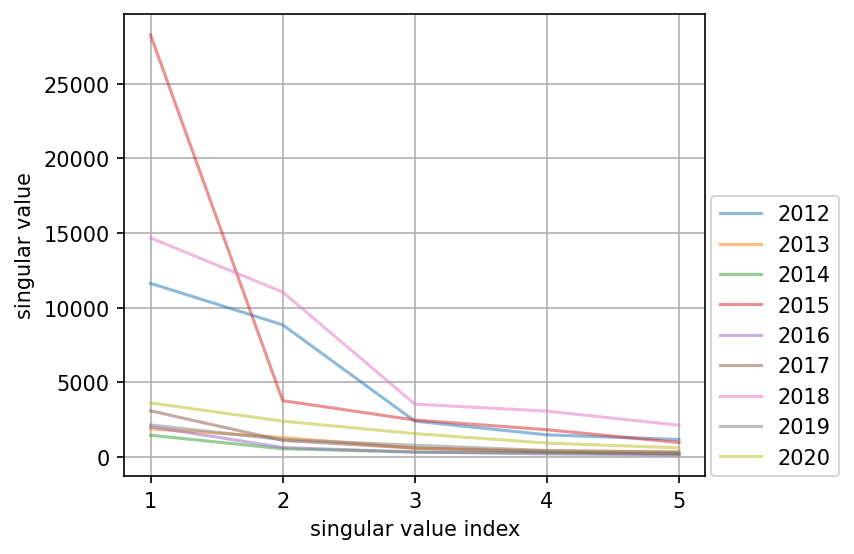

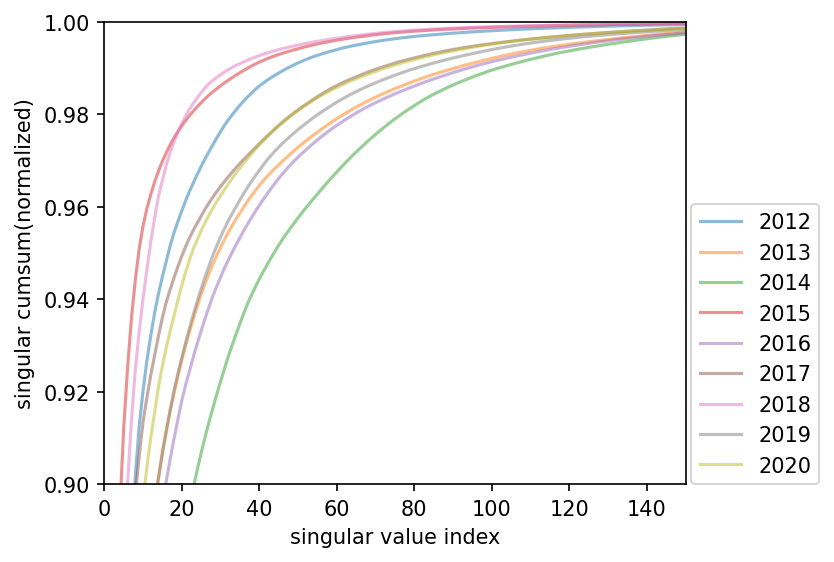

In [8]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.46882739126864637,
 '2013': 0.46297571668501103,
 '2014': 0.46432941514132575,
 '2015': 0.485812143761151,
 '2016': 0.46455903133196075,
 '2017': 0.4636361990094394,
 '2018': 0.48728600061415617,
 '2019': 0.4650025419339191,
 '2020': 0.48979090001029524}

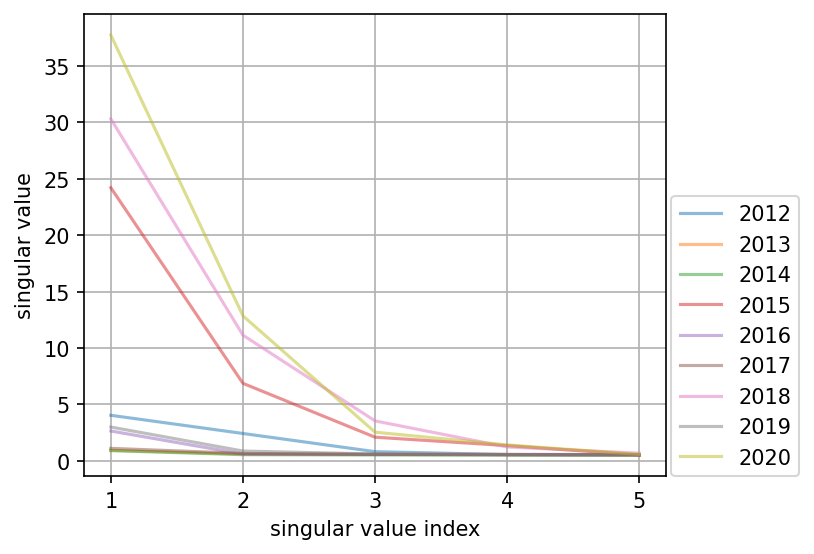

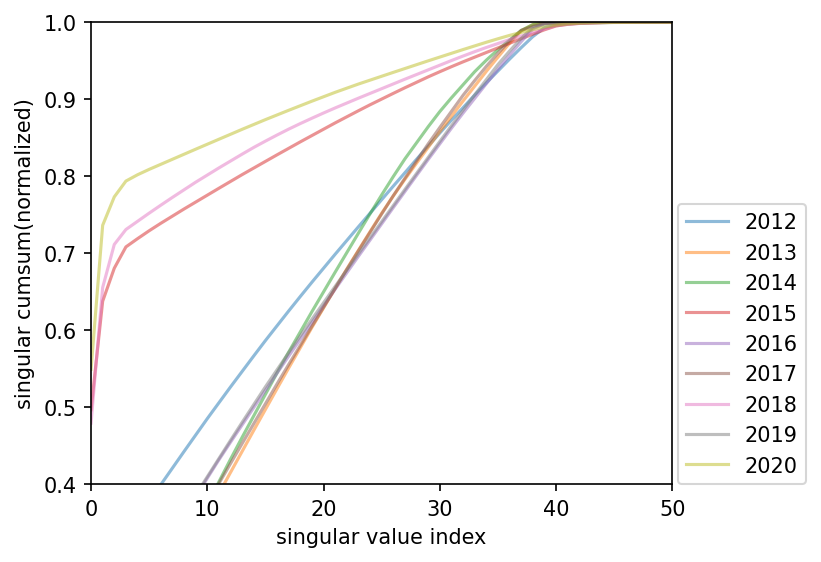

In [13]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.4888285402201138,
 '2013': 0.47988910520051764,
 '2014': 0.4837338777626421,
 '2015': 0.49367503342943186,
 '2016': 0.4826291302058978,
 '2017': 0.4790586287605122,
 '2018': 0.49257027250696517,
 '2019': 0.48480844346317176,
 '2020': 0.4943837218406518}

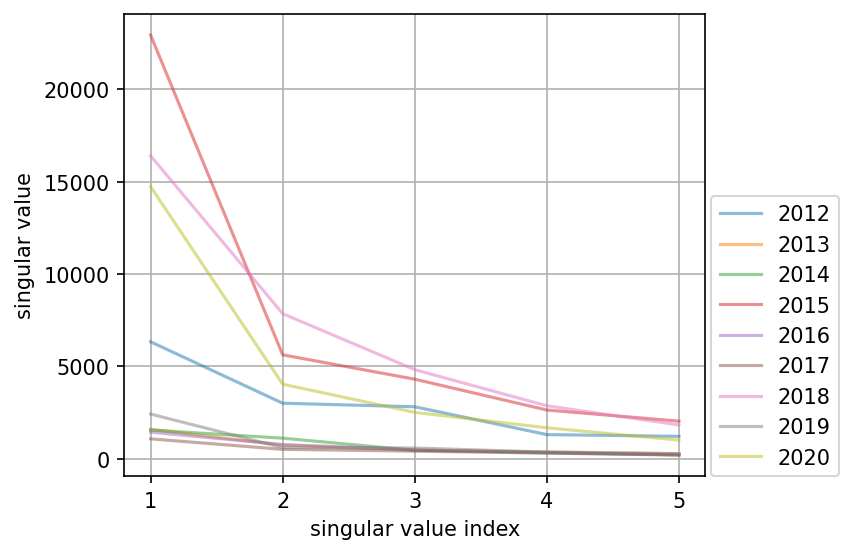

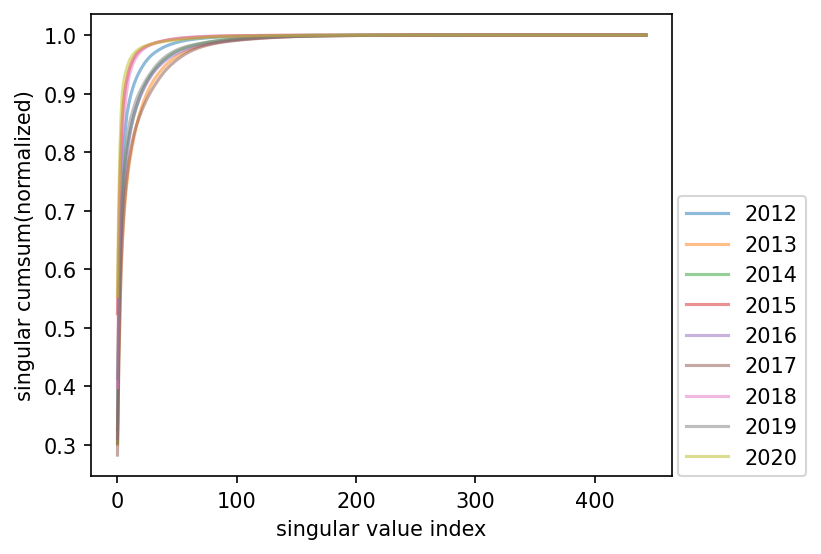

In [4]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.0_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.4630018170385376,
 '2013': 0.46224250516682075,
 '2014': 0.4624851810271845,
 '2015': 0.46182952496477014,
 '2016': 0.4626919236088003,
 '2017': 0.46411287126077316,
 '2018': 0.46191611936155363,
 '2019': 0.463875109049132,
 '2020': 0.4615913403378955}

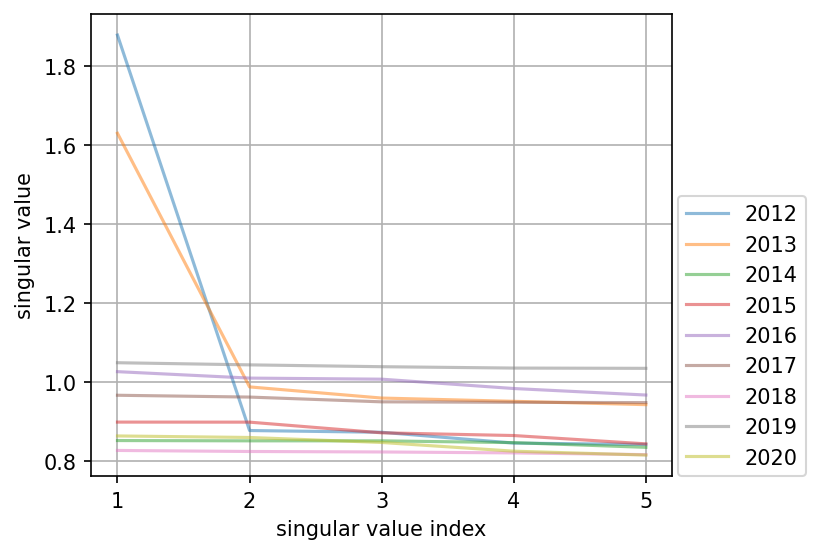

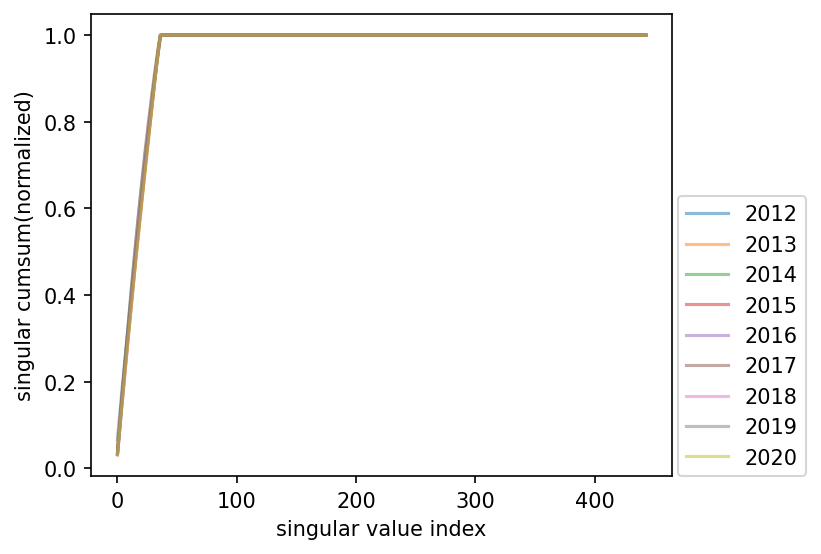

In [6]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.02_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.48590747474373874,
 '2013': 0.4895152647380705,
 '2014': 0.46569377657198396,
 '2015': 0.4959524702032144,
 '2016': 0.46579055763141886,
 '2017': 0.48178316621690553,
 '2018': 0.49992940912820594,
 '2019': 0.4847818354772516,
 '2020': 0.46905325741605775}

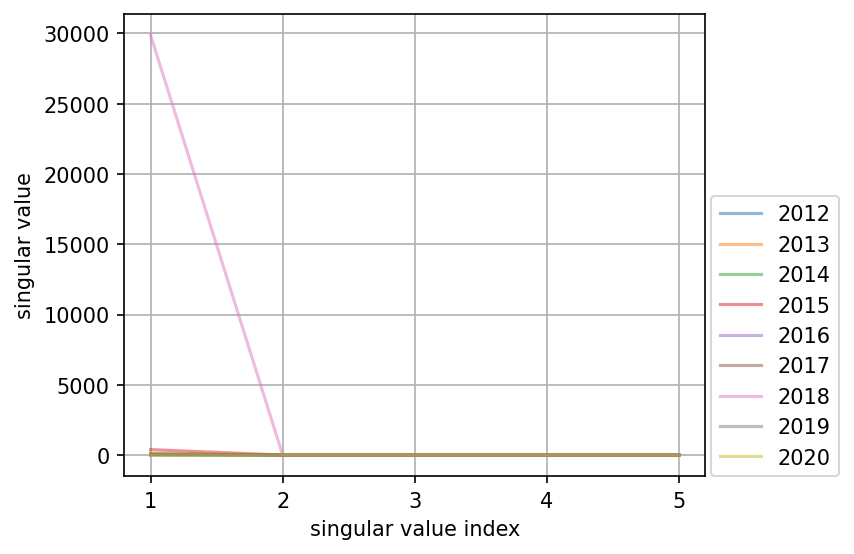

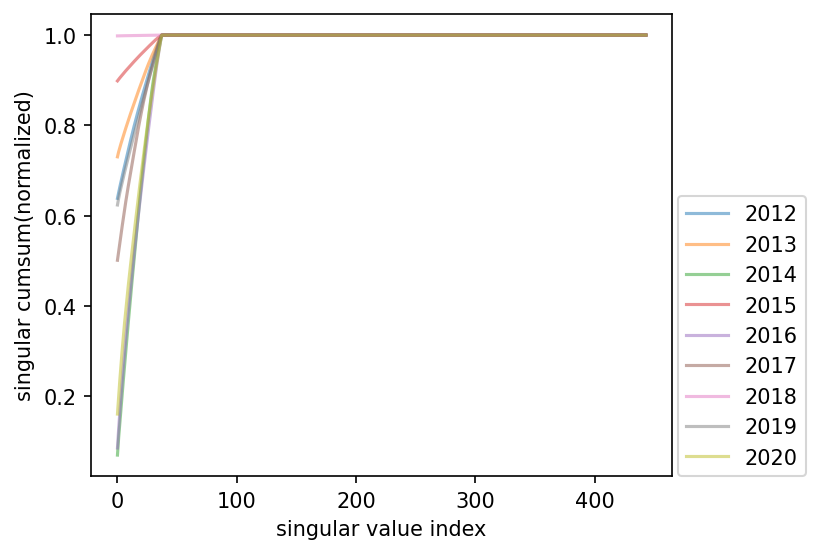

In [8]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.0005_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.4192268132761324,
 '2013': 0.39242569156887785,
 '2014': 0.3960491861568777,
 '2015': 0.43173446719029285,
 '2016': 0.3922501151393507,
 '2017': 0.3895384748438233,
 '2018': 0.43391443776061167,
 '2019': 0.3956114377996274,
 '2020': 0.4202196331490061}

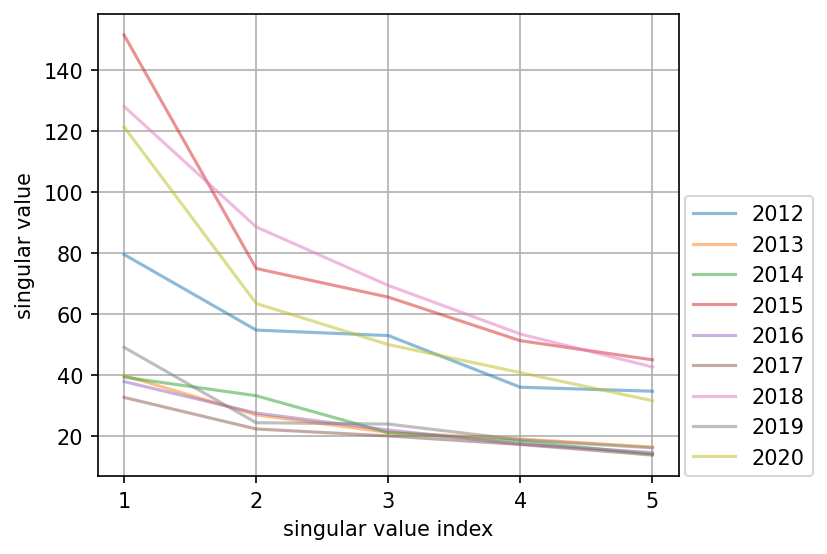

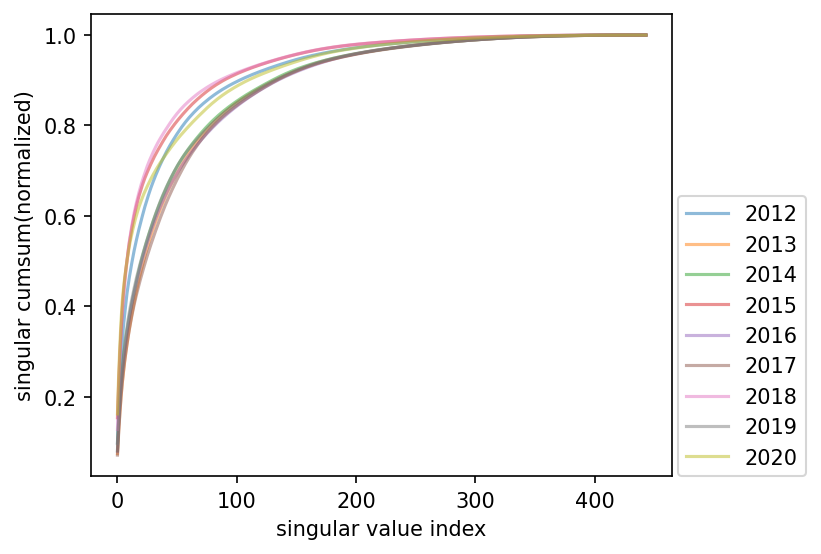

In [9]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.4235649840392566,
 '2013': 0.3923815865379351,
 '2014': 0.3846927954140963,
 '2015': 0.428357511175966,
 '2016': 0.386683695297121,
 '2017': 0.40092965154105975,
 '2018': 0.4366641201868796,
 '2019': 0.397507267454158,
 '2020': 0.4039684926087005}

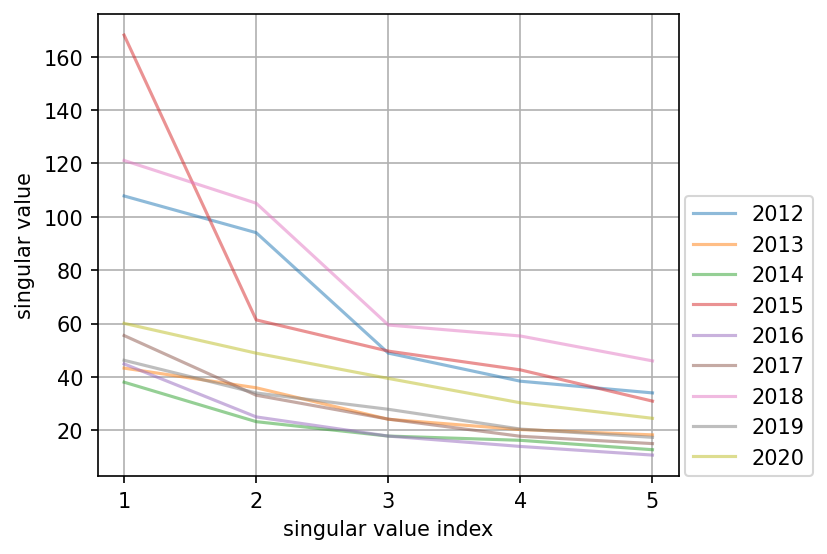

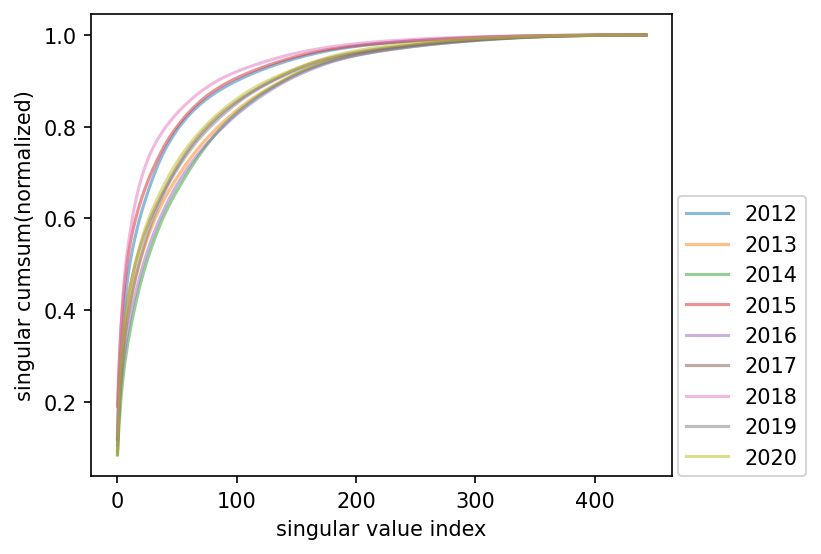

In [5]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
test_id0 = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'
#test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
#plot_singular(test_id0, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
#gn_dic0 = plot_singular_cum(test_id0, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': np.float64(0.4127916855838143),
 '2013': np.float64(0.4034898068651721),
 '2014': np.float64(0.39813582384693424),
 '2015': np.float64(0.4133884032923364),
 '2016': np.float64(0.3958277977029685),
 '2017': np.float64(0.3965376226459141),
 '2018': np.float64(0.4122596433601924),
 '2019': np.float64(0.40057195660876466),
 '2020': np.float64(0.4043368074273893)}

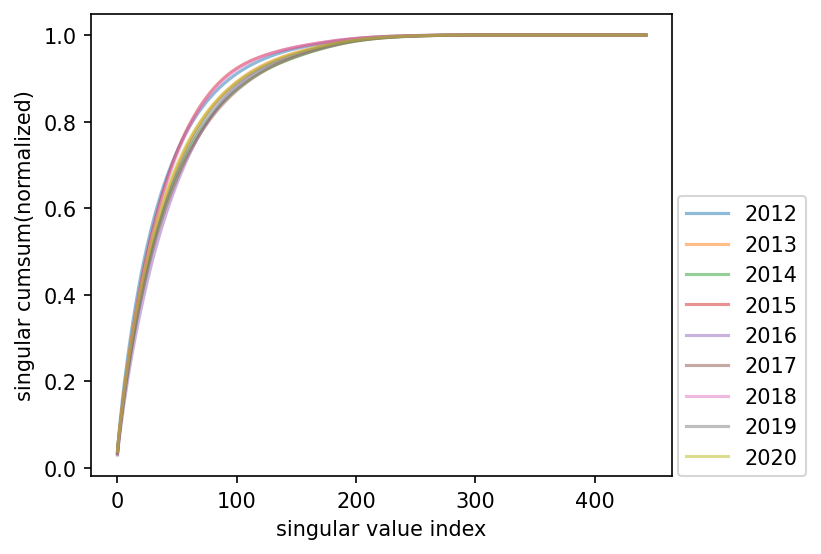

In [4]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': np.float64(0.4632452635422548),
 '2013': np.float64(0.47986298006084493),
 '2014': np.float64(0.46125682415531477),
 '2015': np.float64(0.4672404643840503),
 '2016': np.float64(0.4290361281506142),
 '2017': np.float64(0.4374336897944233),
 '2018': np.float64(0.449221766773663),
 '2019': np.float64(0.4295127090329538),
 '2020': np.float64(0.437953179509767)}

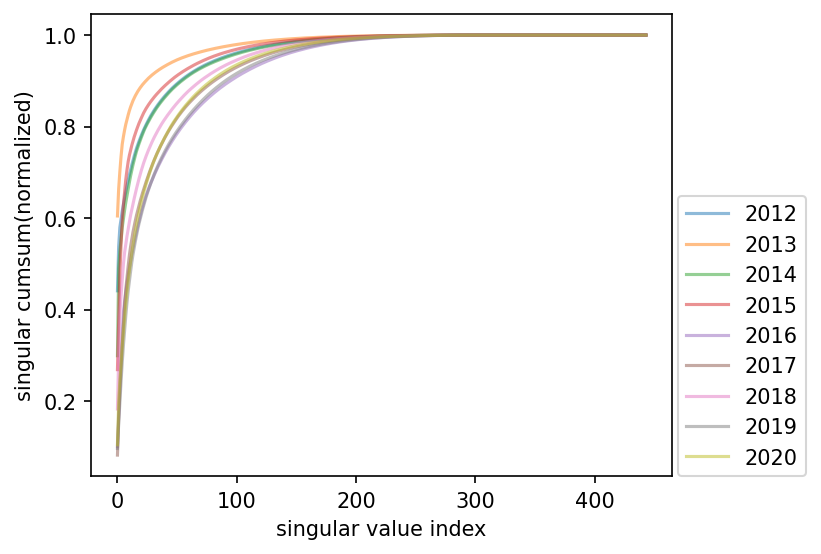

In [5]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

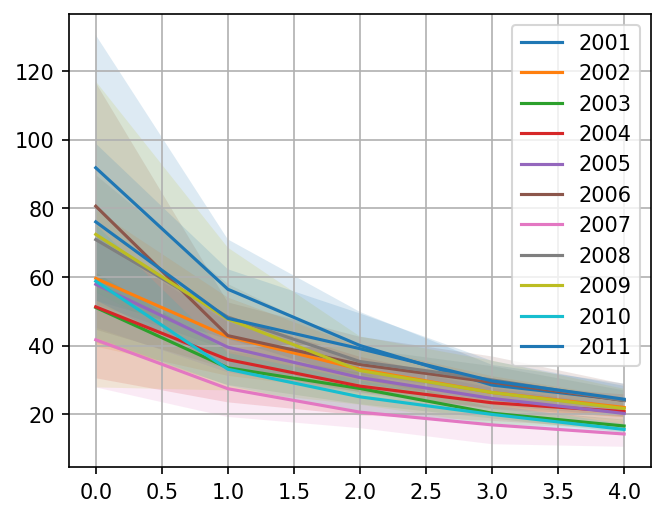

In [67]:
jacs = {i:[] for i in range(720, 852, 12)}
seeds = 10
for expid in range(seeds):
    test_id = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"+str(expid)
    for i in range(720, 852, 12):
        str_i = f'{i:04d}'
        mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(12*36, -1).astype(float)
        u, s, vt = np.linalg.svd(mat)
        jacs[i].append(s) 

plt.figure(figsize=(5,4),dpi=150)
for i in range(720, 852, 12):
    jac_arr = np.array(jacs[i])
    jac_mean = np.mean(jac_arr, axis=0)
    jac_std = np.std(jac_arr, axis=0)
    
    
    plt.plot(jac_mean[:5], label=str(1941+i//12))
    plt.fill_between(range(5), jac_mean[:5]+jac_std[:5], jac_mean[:5]-jac_std[:5], alpha=0.15)
plt.grid()
plt.legend()